<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Uni3KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (KNN con K=3)
               precision    recall  f1-score   support

No Pagado (0)       0.25      0.11      0.15       882
   Pagado (1)       0.86      0.94      0.90      5085

     accuracy                           0.82      5967
    macro avg       0.55      0.53      0.53      5967
 weighted avg       0.77      0.82      0.79      5967


Área Bajo la Curva (AUC): 0.5865
--------------------------------------------------

######################################################################
# INTERPRETACIÓN INDIVIDUAL: KNN (K-Nearest Neighbors) #
######################################################################

1. ¿Cómo funciona el algoritmo?
KNN es un algoritmo no paramétrico basado en instancias. Clasifica un nuevo préstamo basándose en la mayoría de votos de sus K vecinos más cercanos en el espacio de características. La cercanía se mide por la distancia (típicamente Euclideana).

2. Ventajas y limitaciones del modelo.
  - Ventaja: Es simple

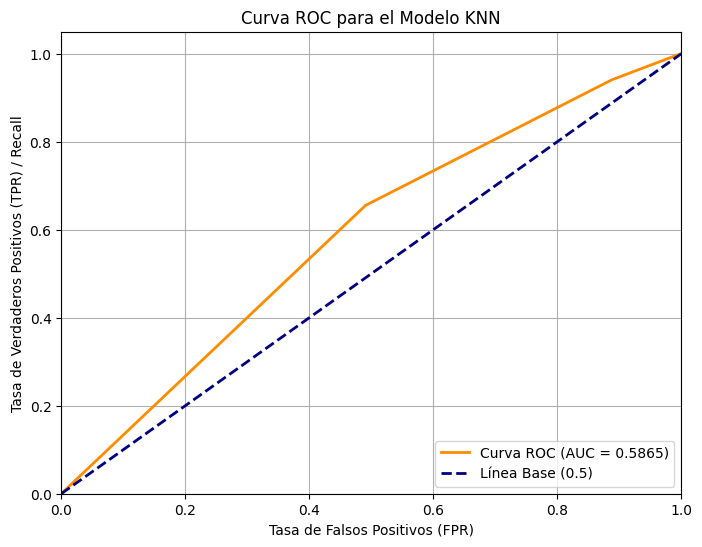

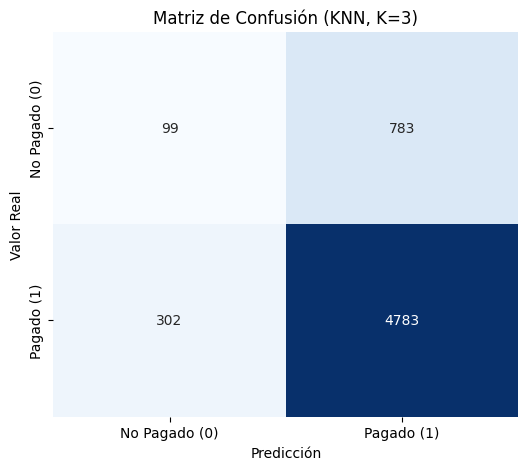

In [4]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO KNN (K-Nearest Neighbors) con ANÁLISIS INTEGRADO
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización de Pandas
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO KNN (PARTE 2) ---

# Se usa K=3 para replicar el resultado del notebook de referencia
best_k = 3
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

# Predicción de CLASES y PROBABILIDADES
y_pred = knn_best.predict(X_test_scaled)
y_proba = knn_best.predict_proba(X_test_scaled)[:, 1]


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (KNN con K=3)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nÁrea Bajo la Curva (AUC): {auc_score:.4f}")
print("-" * 50)


# ==============================================================================
# PARTE 3. INTERPRETACIÓN INDIVIDUAL: KNN (K-Nearest Neighbors)
# ==============================================================================
print("\n" + "#" * 70)
print("# INTERPRETACIÓN INDIVIDUAL: KNN (K-Nearest Neighbors) #")
print("#" * 70)

print("\n1. ¿Cómo funciona el algoritmo?")
print("KNN es un algoritmo no paramétrico basado en instancias. Clasifica un nuevo préstamo basándose en la mayoría de votos de sus K vecinos más cercanos en el espacio de características. La cercanía se mide por la distancia (típicamente Euclideana).")

print("\n2. Ventajas y limitaciones del modelo.")
print("  - Ventaja: Es simple, no hace suposiciones sobre la distribución de los datos.")
print("  - Limitación: Requiere el **escalamiento obligatorio** de las variables y tiene un alto costo computacional para la predicción en grandes datasets.")

recall_no_pagado = recall_score(y_test, y_pred, pos_label=0)
print(f"\n3. Interpretación de resultados (Recall No Pagado = {recall_no_pagado:.2f}).")
print("El modelo KNN **no detecta bien los créditos 'No Pagados'**. El Recall para la Clase 0 es extremadamente bajo. Esto significa que la gran mayoría de los préstamos que realmente incumplieron no fueron identificados (altos Falsos Negativos), lo cual es inaceptable para la gestión de riesgo.")

print("\n4. Posibles causas del rendimiento obtenido.")
print("La causa principal es el **Desbalance de Clases**. Dado que la clase 'Pagado' es mayoritaria, los K vecinos más cercanos a cualquier nuevo préstamo tienden a pertenecer a la clase mayoritaria, sesgando la predicción y minimizando el Recall para la clase minoritaria ('No Pagado').")

print("\n5. Recomendaciones de mejora.")
print("  - **Balanceo de Clases:** Aplicar técnicas de remuestreo (ej. **SMOTE**) en el conjunto de entrenamiento para nivelar el número de casos 'No Pagados'.")
print("  - **Tuning de Métrica:** Reevaluar el modelo optimizando el *scoring* para **Recall de la Clase 0** durante el GridSearchCV, no solo para la Accuracy.")
print("#" * 70)
# ==============================================================================
# FIN DE LA PARTE 3 DEL PROYECTO
# ==============================================================================


# 4.3 Generación del Gráfico de Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo KNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 4.4 Gráfico de la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title(f'Matriz de Confusión (KNN, K={best_k})')
plt.show()